## musicntwrk - advanced machine learning of sounds

 A python library for pitch class set and rhythmic sequences classification and manipulation,
 the generation of networks in generalized musical spaces, and the sonification of arbitrary data
 See documentation at www.musicntwrk.com 

 Copyright (C) 2018,2019,2020 Marco Buongiorno Nardelli
 http://www.materialssoundmusic.com, mbn@unt.edu

 This file is distributed under the terms of the
 GNU General Public License. See the file `License'
 in the root directory of the present distribution,
 or http://www.gnu.org/copyleft/gpl.txt .

For a high quality graphics representation of networks, node and edge files can be written to disk in csv format and directly imported in visualization programs like Gephi (www.gephi.org)

To display musicxml in notation format a notation app should be installed (see for instance www.musescore.org) and should be defined in music21 preferences (see https://web.mit.edu/music21/doc/usersGuide/usersGuide_08_installingMusicXML.html)

#### Installation

pip install musicntwrk  
or  
pip install musicntwrk[with_MPI]  
(if there is a pre-existing installation of MPI, pip will automatically install the mpi4pi wrapper)

In [1]:
import re, sys, os, time, wget
from zipfile import ZipFile
import numpy as np

from musicntwrk import musicntwrk
from musicntwrk.plotting.drawNetwork import drawNetwork
mk = musicntwrk.musicntwrk(TET=12)

from musicntwrk import musicntwrk
from musicntwrk.ml_utils.checkRun import checkRun
from musicntwrk.ml_utils.multiModelPredictor import multiModelPredictor
from musicntwrk.ml_utils.readModels import readModels
from musicntwrk.ml_utils.trainNNmodel import trainNNmodel
from musicntwrk.ml_utils.trainCNNmodel import trainCNNmodel

### Machine learning of sounds 

## this example requires large (~1.25 GBytes) databases of sounds in wav format included in the examples directory on GitHub

NOTE: to extract N random soundfiles and move them in a different directory: <br>
ls |sort -R |tail -N| xargs -I {} mv {} PERCEPTION/<br>
This is to create the training and the validation set - this has been already done: two databases need to be downloaded (see following)

#### The following needs to be run only once

In [7]:
with ZipFile('PERCEPTION.zip', 'r') as zip:
    zip.extractall()
with ZipFile('MODEL.zip', 'r') as zip:
    zip.extractall()

Build a training model based on the mfcc of the sounds in MODEL/ (*this step might take some time*)

In [ ]:
waves,mfcc,lmax = mk.timbre(descriptor='MFCC',standard=True,path='./MODEL',
                            wavefil='*.wav',nmel=16,ncc=13,nbins=64,lmax=220500)

### in case multiple runs are desired, it is convenient to save the MODEL data and read in from file

In [31]:
np.save('mfccSPLICE',mfcc)
np.save('mfcc_wavesSPLICE',waves)
np.save('lmaxSPLICE',lmax)

In [2]:
mfcc = np.load('mfccSPLICE.npy')
waves = np.load('mfcc_wavesSPLICE.npy')
lmax = np.load('lmaxSPLICE.npy')

Create datasaet for ML

In [3]:
# labels for determining the origin of sound (wood or metal)
label = np.zeros(mfcc.shape[0],dtype=int)
for n in range(mfcc.shape[0]):
    if re.search("IRON", waves[n]): label[n] = 0
    elif re.search("WOOD", waves[n]): label[n] = 1
    elif re.search("metal", waves[n]): label[n] = 0
    elif re.search("wood", waves[n]): label[n] = 1
    else: print('missing label')

name = np.zeros(2,dtype=object)
name[0] = 'iron'
name[1] = 'wood'

__Train a neural network (NN) model on the MODEL data__ - here it is done only once (niter=1); in production, it should be run multiple times with a strict threshold for accuracy. If accepted, the model is saved to file and the name displayed. All the best can be sets combined in a multi-model predictor

loss  0.3612830638885498 accuracy  0.904347836971283
Model:  None


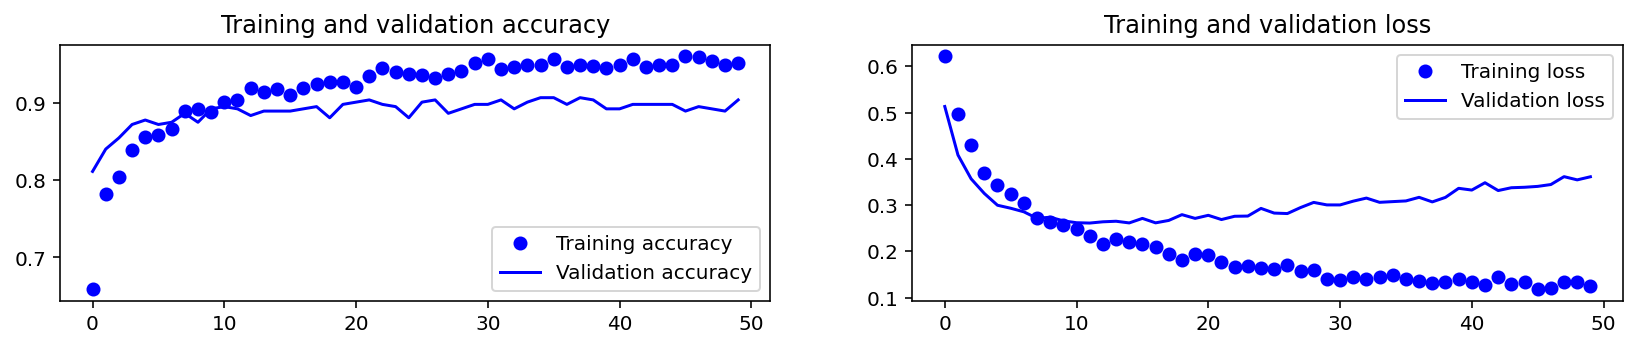

In [4]:
model,_,_,_,_,scaler,normal,_,train = trainNNmodel(mfcc,label,niter=1,nstep=10,neur=16,test=0.20,num_classes=2,
                                         epoch=50,verb=0,thr=0.90,w=False)
checkRun(train,None)

Check one of the sounds in PERCEPTION/ - for demo purpose only, the accuracy of the NN is probably very low

In [7]:
path = './PERCEPTION'
file = 'ad3_garage_wood_lumber_impact_42.wav'
wread0,mread0,_ = mk.timbre(descriptor='MFCC',standard=True,path=path,wavefil=file,
                            nmel=16,ncc=13,lmax=lmax,nbins=64)
xnew = np.asarray(mread0)
idx,prob = multiModelPredictor(xnew,model,scaler,normal)

print('Predicted: ',name[idx],'\n')
print('\t\t',np.array2string(name,separator='  '))
print('Probability: \t',round(prob[0]*100,0),'     ',round(prob[1]*100,0))

Predicted:  wood 

		 ['iron'  'wood']
Probability: 	 33.0       67.0


__Train a convolutional neural network (CNN) model on the MODEL data__ - here it is done only once (niter=1); in production, it should be run multiple times with a strict threshold for accuracy. If accepted, the model is saved to file and the name displayed. All the best sets can be combined in a multi-model predictor<br>
### in the following we set the threshold unreasonably low in order to demonstrate how to build a multi-model predictor
The following cell should produce two model files. If not, re-run the cell until the CNN is able to produce two sets - *given the better performance of CNNs this should not happen often*

In [8]:
model,_,_,_,_,_,_,_,train = trainCNNmodel(mfcc,label,gpu=0,cpu=4,niter=2,neur=8,test=0.08,
                                                    num_classes=2,epoch=30,verb=0,thr=0.7,w=True)

loss  0.19729486107826233 accuracy  0.9130434989929199
found good match  0.913
model saved in  0x5f05fc33_0.913
loss  0.19702474772930145 accuracy  0.9275362491607666
found good match  0.928
model saved in  0x5f05fc43_0.928


Model:  ./0x5f05fc33_0.913.h5


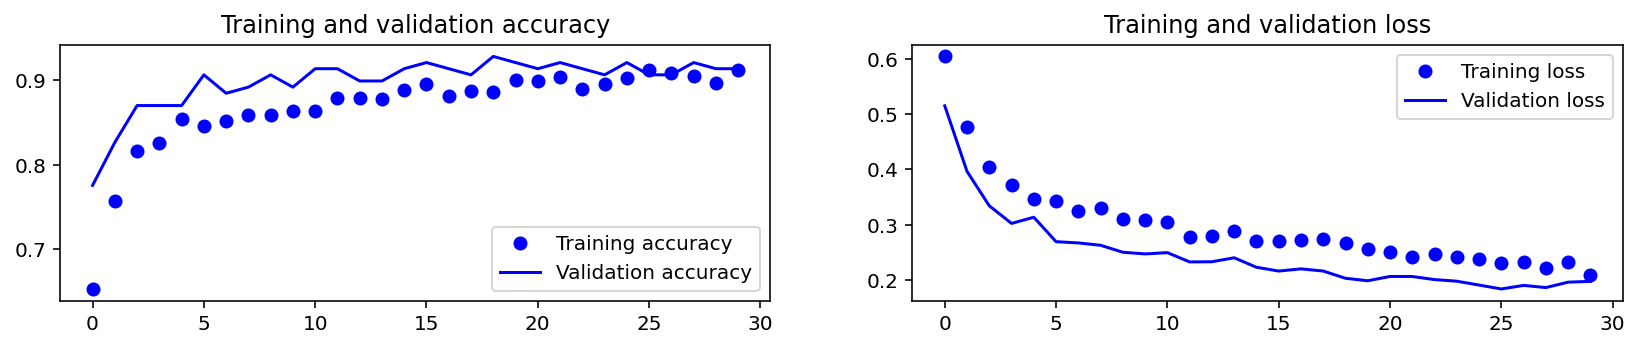

Model:  ./0x5f05fc43_0.928.h5


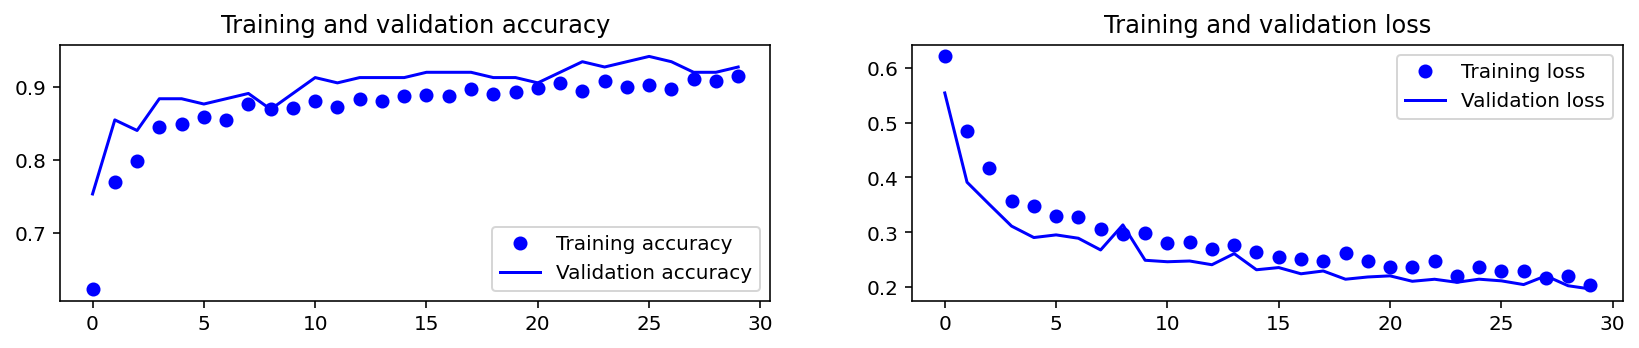

In [9]:
models,scalers,normals,trdict,modelfiles = readModels('./','*.tar')
checkRun(trdict,modelfiles)

Check the sound in PERCEPTION/ as above - for demo purpose only, the accuracy of the CNN is probably very low

In [10]:
path = './PERCEPTION'
file = 'ad3_garage_wood_lumber_impact_42.wav'
wread0,mread0,_ = mk.timbre(descriptor='MFCC',standard=True,path=path,wavefil=file,
                            nmel=16,ncc=13,lmax=lmax,nbins=64)
xnew = np.asarray(mread0)
idx,prob = multiModelPredictor(xnew,models,scalers,normals)

print('Predicted: ',name[idx],'\n')
print('\t\t',np.array2string(name,separator='  '))
# print('Probability: \t',round(prob[0][0]*100,0),'     ',round(prob[0][1]*100,0))
print('Probability: \t',round(prob[0]*100,0),'     ',round(prob[1]*100,0))

Predicted:  wood 

		 ['iron'  'wood']
Probability: 	 14.0       86.0


#### Generate the network of the mfcc in PERCEPTION

In [11]:
waves,mfcc,lmax = mk.timbre(descriptor='MFCC',standard=True,path='./PERCEPTION',
                            wavefil='*.wav',nmel=16,nbins=64,lmax=22050)

/Users/marco/anaconda3/envs/musica/lib/python3.10/site-packages/musicntwrk/timbre/computeStandardizedMFCC.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wf = np.array(wf)


In [15]:
import pandas as pd

In [16]:
pd.__version__

'1.5.3'

In [12]:
nodes,edges = mk.network(space='timbre',wavefil=waves,cepstrum=mfcc,thup=240,thdw=24)

/Users/marco/anaconda3/envs/musica/lib/python3.10/site-packages/musicntwrk/networks/timbralNetwork.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dnodes = dnodes.append(nameseq)
/Users/marco/anaconda3/envs/musica/lib/python3.10/site-packages/musicntwrk/networks/timbralNetwork.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dnodes = dnodes.append(nameseq)
/Users/marco/anaconda3/envs/musica/lib/python3.10/site-packages/musicntwrk/networks/timbralNetwork.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dnodes = dnodes.append(nameseq)
/Users/marco/anaconda3/envs/musica/lib/python3.10/site-packages/musicntwrk/networks/timbralNetwork.py:49: FutureWarning: The frame.append method is deprecated and will be removed fr

found  [  2   3   4   8  11 142]  connected components
enter index -1


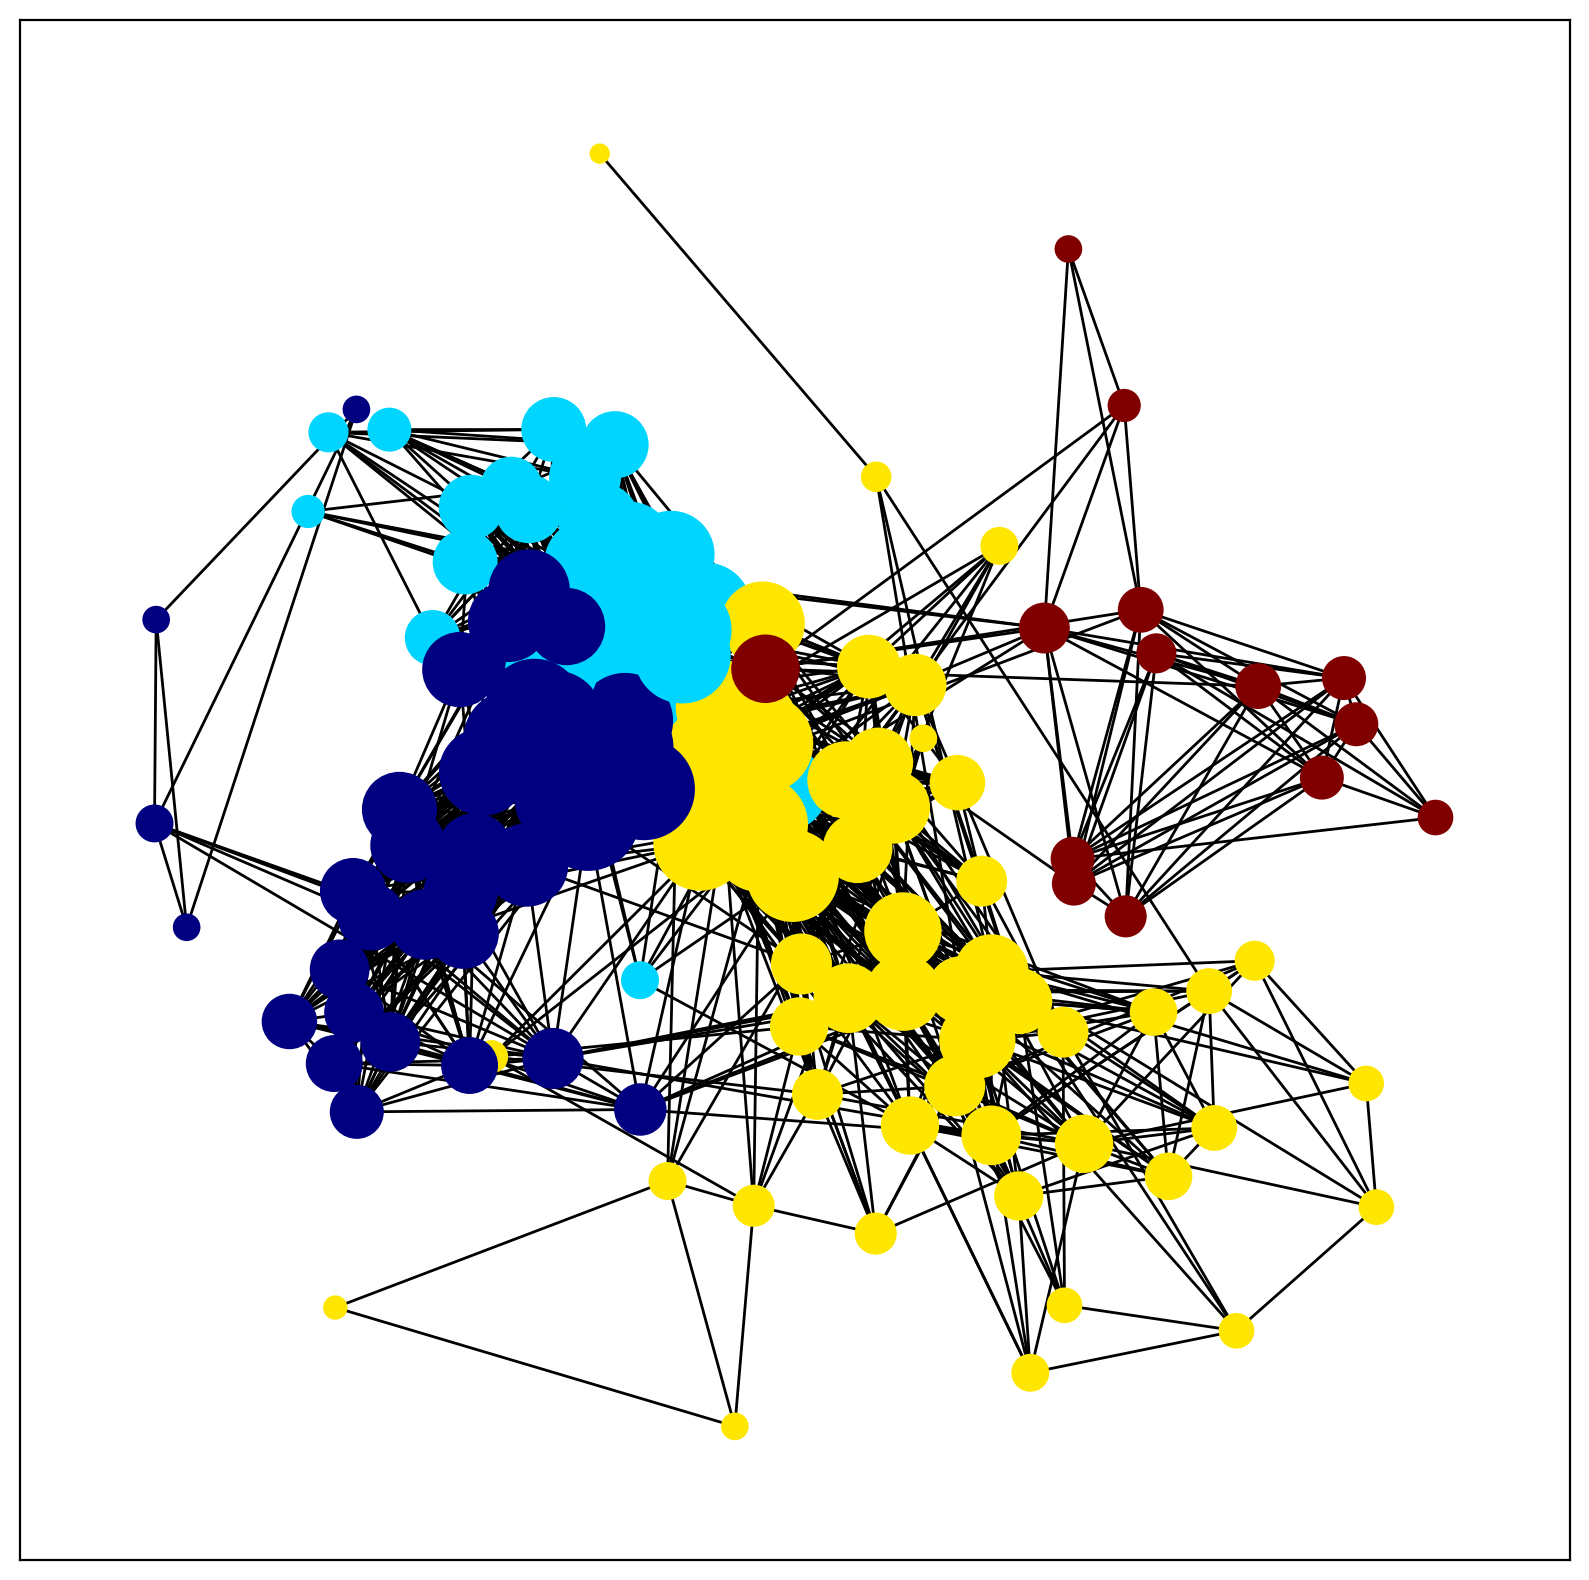

In [13]:
# giant connected component of the MFCC network with the current thersholds
drawNetwork(nodes=nodes,edges=edges,scale=0.2,drawlabels=False,giant=True)